# Seismic Receiver Function Inversion

Receiver functions are a common observable in seismology.
They represent the conversion of the form of energy of seismic waves from compressional to transverse (and vice versa) at geological interfaces.
Details aside, the aim of a receiver function inversion is to determine the seismic structure at a point down to a depth of a few tens of kilometers.
Typically the subsurface is parameterised as a few layers of constant velocity, where the thickness, velocity (and potentially even number) of layers are unknowns to be solved for.

This example uses the [`espresso`](https://geo-espresso.readthedocs.io/en/latest/index.html) library to provide data, a forward solver and other utilities related to a receiver function inversion.

In [1]:
from espresso import ReceiverFunctionInversion
import numpy as np
import matplotlib.pyplot as plt

from neighpy import NASearcher, NAAppraiser

## Set up `Espresso` Receiver Function Inversion

We start with a problem where we want to find the seismic velocity in fixed layers.

In [2]:
rfi = ReceiverFunctionInversion(example_number=2)
rfi.description

'Inverting velocities of 5 layers'

Lets have a look at the data

<Axes: xlabel='Time/s', ylabel='Amplitude'>

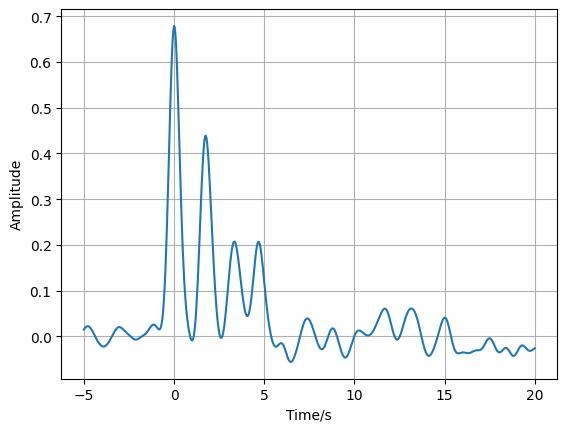

In [3]:
rfi.plot_data(rfi.data)

To first order, every peak in the receiver function is caused by a seismic discontinuity (change in seismic velocity).

And now let's look at what a "good" model looks like, and a potential starting model

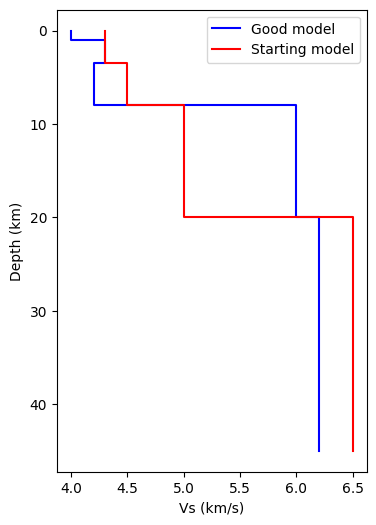

In [4]:
ax = rfi.plot_model(rfi.good_model, rfi.starting_model, "Good model", "Starting model")
ax.legend()

Out of curiosity, let's see how well these models fit the observed data

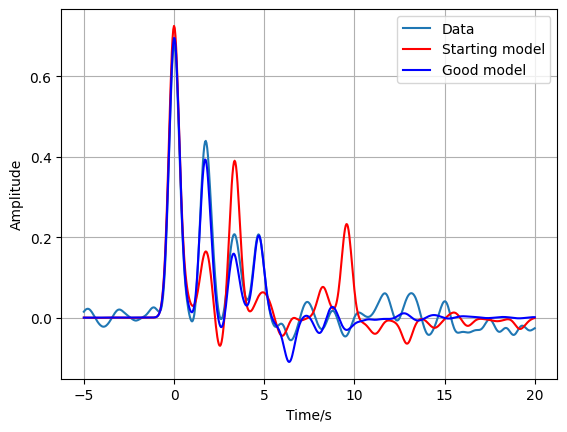

In [5]:
ax = rfi.plot_data(rfi.data, label="Data")
for name, (model, colour) in {"Starting model" : [rfi.starting_model, "r"], "Good model": [rfi.good_model, "b"]}.items():
    synth = rfi.forward(model)
    ax.plot(rfi._t, synth, label=name, c=colour)
ax.legend()


## Set up Neighbourhood Algorithm with `Neighpy`

`Espresso`  provides us with a `log_likelihood` function, which we can use as our objective function (although remember to multiply by -1 since we want to minimise the objective!).
We can choose the `bounds` on the velocity in each layer as we wish.
These should be generally increasing with depth.

In [6]:
searcher = NASearcher(
    objective=lambda m: -1 * rfi.log_likelihood(rfi.data, rfi.forward(m)),
    bounds=[(3.5, 7.0)] * rfi.model_size,
    ni=2000,  # size of initial population
    ns=50,  # number of new samples at each iteration
    nr=10,  # number of neighbourhoods to resample at each iteration
    n=100  # number of iterations
)

searcher.run(parallel=False)  # some serialisation issues with the EspressoProblem object preventing parallelisation

best_i = np.argmin(searcher.objectives)
best = searcher.samples[best_i]

NAI - Initial Random Search


NAI - Optimisation Loop: 100%|██████████| 100/100 [00:08<00:00, 12.38it/s]


A rather crude check on the convergence

Text(0.95, 0.95, 'Neighbourhood Search')

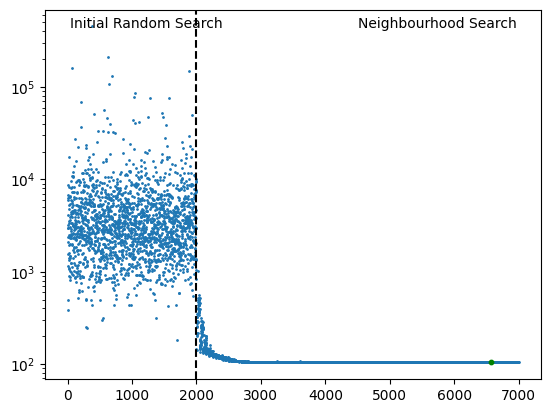

In [7]:
plt.plot(searcher.objectives, marker=".", linestyle="", markersize=2)
plt.scatter(best_i, searcher.objectives[best_i], c="g", s=10, zorder=10)
plt.axvline(searcher.ni, c="k", ls="--")
plt.yscale("log")
plt.text(0.05, 0.95, "Initial Random Search", transform=plt.gca().transAxes, ha="left")
plt.text(0.95, 0.95, "Neighbourhood Search", transform=plt.gca().transAxes, ha="right")

Plot models

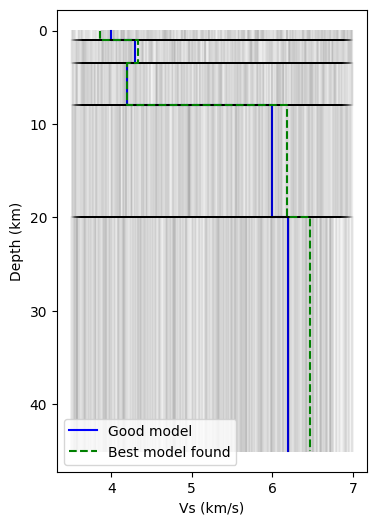

In [8]:
def _plot_model(model):
    model_setup = rfi._model_setup(model)
    px = np.zeros([2 * len(model_setup), 2])
    px[0::2, 0] = model_setup[:, 1]
    px[1::2, 0] = model_setup[:, 1]
    px[1::2, 1] = model_setup[:, 0]
    px[2::2, 1] = model_setup[:-1, 0]
    return px


ax = rfi.plot_model(
    rfi.good_model,
    label="Good model",
)
for model in searcher.samples[:searcher.ni]:
    ax.plot(*_plot_model(model).T, c="k", alpha=0.01)
ax.plot(
    *_plot_model(searcher.samples[np.argmin(searcher.objectives)]).T,
    "g--",
    label="Best model found"
)
ax.legend(loc="lower left")

Plot predicted data

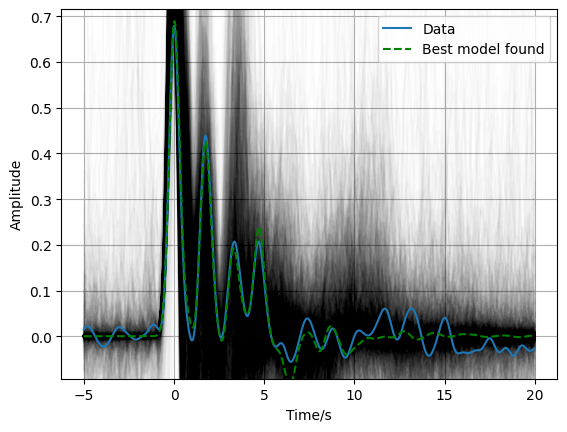

In [9]:
ax = rfi.plot_data(rfi.data, label="Data")
_ylim = ax.get_ylim()
for model in searcher.samples[:searcher.ni]:
    ax.plot(rfi._t, rfi.forward(model), c="k", alpha=0.01)
ax.get_lines()[0].set_zorder(10)
ax.plot(rfi._t, rfi.forward(best), "g--", label="Best model found", zorder=11)
ax.set_ylim(_ylim)
ax.legend()

Pretty decent! Now to independently resample the posterior using the Appraisal phase of the NA.

In [10]:
appraiser = NAAppraiser(searcher=searcher, n_resample=20000, n_walkers=10)
appraiser.run()

NAII - Random Walk: 100%|██████████| 2000/2000 [00:43<00:00, 45.54it/s]


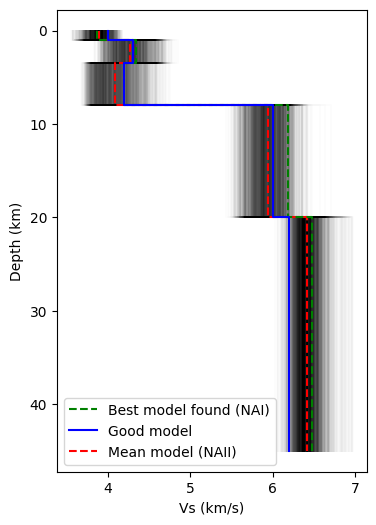

In [17]:
ax = rfi.plot_model(best, rfi.good_model, label="Best model found (NAI)", label2="Good model")
for model in appraiser.samples[::10]:
    ax.plot(*_plot_model(model).T, c="k", alpha=0.01)
ax.get_lines()[0].set_color("g")
ax.get_lines()[0].set_linestyle("--")
ax.get_lines()[0].set_zorder(10)
ax.get_lines()[1].set_zorder(10)
ax.get_lines()[1].set_color("b")
ax.plot(*_plot_model(appraiser.mean).T, "r--", label="Mean model (NAII)")
ax.legend(loc="lower left")

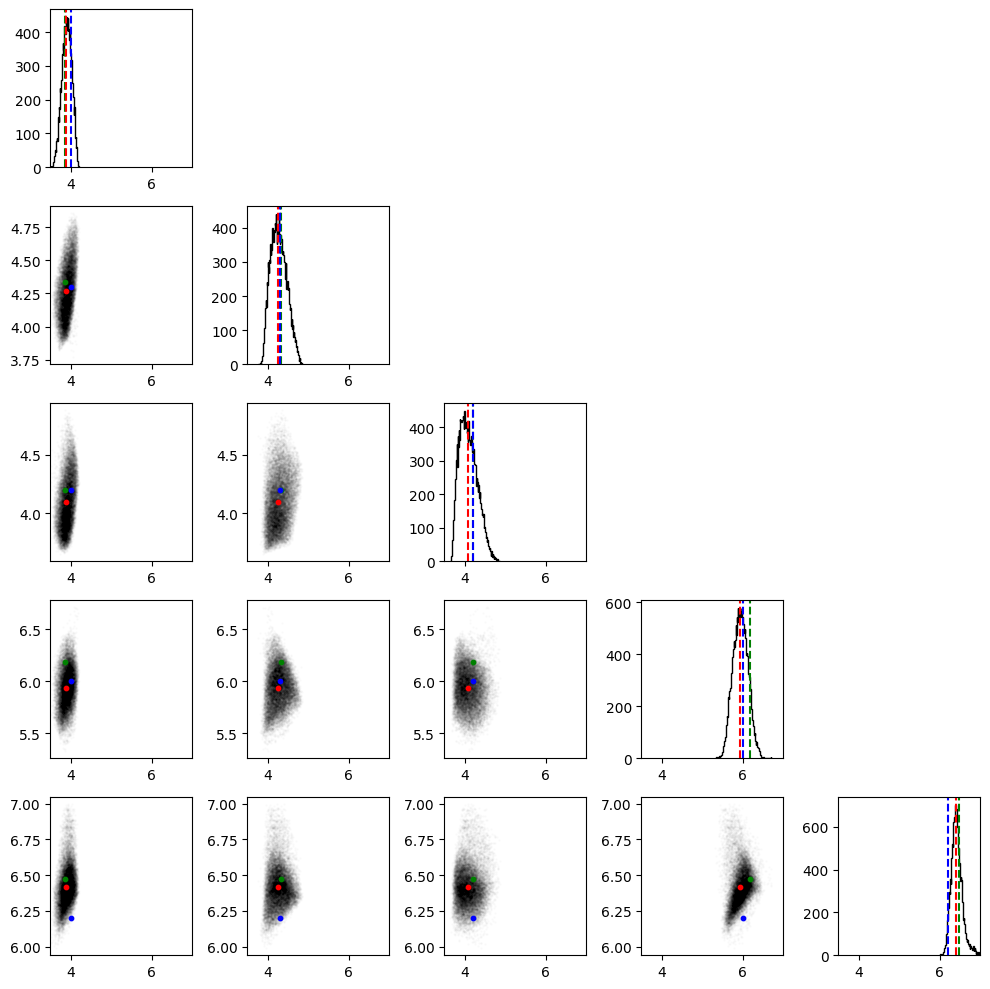

In [30]:
fig, ax = plt.subplots(rfi.model_size, rfi.model_size, figsize=(10, 10), tight_layout=True)
for i in range(rfi.model_size):
    for j in range(rfi.model_size):
        ax[i, j].set_xlim(searcher.bounds[j])
        if i == j:
            ax[i, j].hist(appraiser.samples[:, j], bins=100, histtype="step", color="k")
            ax[i, j].axvline(best[j], c="g", ls="--")
            ax[i, j].axvline(rfi.good_model[j], c="b", ls="--")
            ax[i, j].axvline(appraiser.mean[j], c="r", ls="--")
        elif j<i:
            ax[i, j].scatter(appraiser.samples[:, j], appraiser.samples[:, i], s=1, c="k", alpha=0.01)
            ax[i, j].scatter(best[j], best[i], c="g", s=10, zorder=10)
            ax[i, j].scatter(rfi.good_model[j], rfi.good_model[i], c="b", s=10, zorder=10)
            ax[i, j].scatter(appraiser.mean[j], appraiser.mean[i], c="r", s=10, zorder=10)
        else:
            ax[i, j].axis("off")

## A more complicated inversion

What if we also wanted to invert for the interface depths?

In [31]:
rfi = ReceiverFunctionInversion(example_number=3)
rfi.description

'Inverting depths and velocities of 5 layers'

In [32]:
searcher = NASearcher(
    objective=lambda m: -1 * rfi.log_likelihood(rfi.data, rfi.forward(m)),
    bounds=[(0.1, 2), (3.5, 7.0),
            (0.5, 5), (3.5, 7.0),
            (2, 15), (3.5, 7.0),
            (10, 25), (3.5, 7.0),
            (15, 50), (3.5, 7.0),],
    ni=5000,  # size of initial population
    ns=200,  # number of new samples at each iteration
    nr=50,  # number of neighbourhoods to resample at each iteration
    n=100  # number of iterations
)

searcher.run(parallel=False)  # some serialisation issues with the EspressoProblem object preventing parallelisation

best_i = np.argmin(searcher.objectives)
best = searcher.samples[best_i]

NAI - Initial Random Search


NAI - Optimisation Loop: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Text(0.95, 0.95, 'Neighbourhood Search')

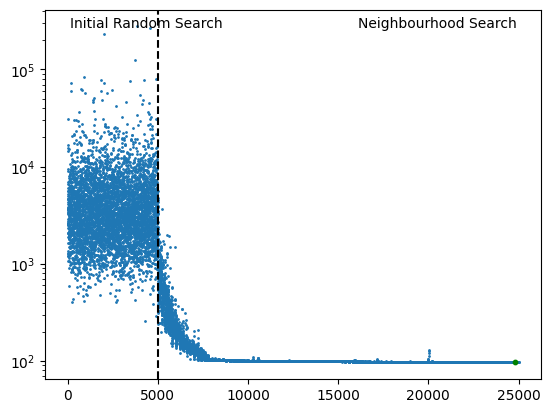

In [33]:
plt.plot(searcher.objectives, marker=".", linestyle="", markersize=2)
plt.scatter(best_i, searcher.objectives[best_i], c="g", s=10, zorder=10)
plt.axvline(searcher.ni, c="k", ls="--")
plt.yscale("log")
plt.text(0.05, 0.95, "Initial Random Search", transform=plt.gca().transAxes, ha="left")
plt.text(0.95, 0.95, "Neighbourhood Search", transform=plt.gca().transAxes, ha="right")

In [35]:
appraiser = NAAppraiser(searcher=searcher, n_resample=75000, n_walkers=15)
appraiser.run()

NAII - Random Walk: 100%|██████████| 5000/5000 [25:58<00:00,  3.21it/s]


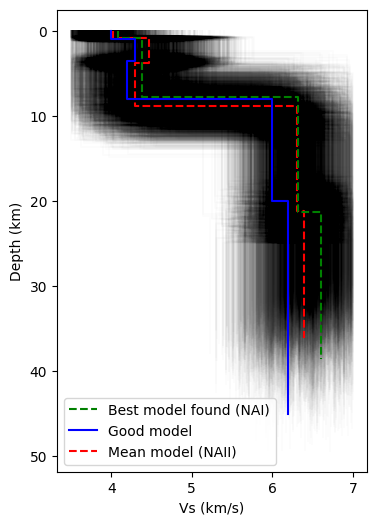

In [36]:
ax = rfi.plot_model(best, rfi.good_model, label="Best model found (NAI)", label2="Good model")
for model in appraiser.samples[::10]:
    ax.plot(*_plot_model(model).T, c="k", alpha=0.01)
ax.get_lines()[0].set_color("g")
ax.get_lines()[0].set_linestyle("--")
ax.get_lines()[0].set_zorder(10)
ax.get_lines()[1].set_zorder(10)
ax.get_lines()[1].set_color("b")
ax.plot(*_plot_model(appraiser.mean).T, "r--", label="Mean model (NAII)")
ax.legend(loc="lower left")

Text(0, 0.5, '')

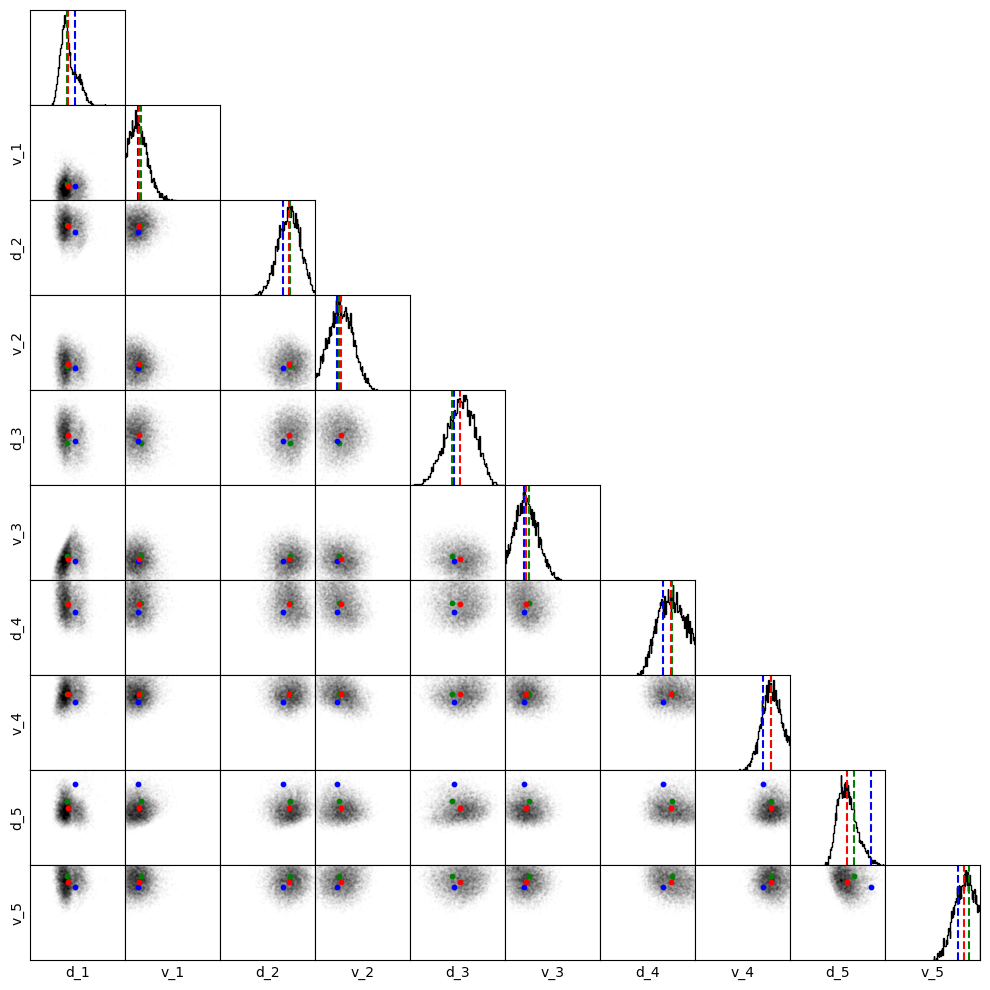

In [56]:
fig, ax = plt.subplots(rfi.model_size, rfi.model_size, figsize=(10, 10), tight_layout=True, gridspec_kw={"hspace": 0, "wspace": 0})
for i in range(rfi.model_size):
    for j in range(rfi.model_size):
        ax[i, j].set_xlim(searcher.bounds[j])
        ax[i, j].set_xticks([], [])
        ax[i, j].set_yticks([], [])
        if i == j:
            ax[i, j].hist(appraiser.samples[::10, j], bins=100, histtype="step", color="k")
            ax[i, j].axvline(best[j], c="g", ls="--")
            ax[i, j].axvline(rfi.good_model[j], c="b", ls="--")
            ax[i, j].axvline(appraiser.mean[j], c="r", ls="--")
        elif j<i:
            ax[i, j].scatter(appraiser.samples[::10, j], appraiser.samples[::10, i], s=1, c="k", alpha=0.01)
            ax[i, j].scatter(best[j], best[i], c="g", s=10, zorder=10)
            ax[i, j].scatter(rfi.good_model[j], rfi.good_model[i], c="b", s=10, zorder=10)
            ax[i, j].scatter(appraiser.mean[j], appraiser.mean[i], c="r", s=10, zorder=10)
            ax[i, j].set_ylim(searcher.bounds[i])
        else:
            ax[i, j].axis("off")

for ax_, xlabel in zip(ax[-1, :], ["d_1", "v_1", "d_2", "v_2", "d_3", "v_3", "d_4", "v_4", "d_5", "v_5"]):
    ax_.set_xlabel(xlabel)
for ax_, ylabel in zip(ax.T[0, :], ["d_1", "v_1", "d_2", "v_2", "d_3", "v_3", "d_4", "v_4", "d_5", "v_5"]):
    ax_.set_ylabel(ylabel)
ax[0,0].set_ylabel("")

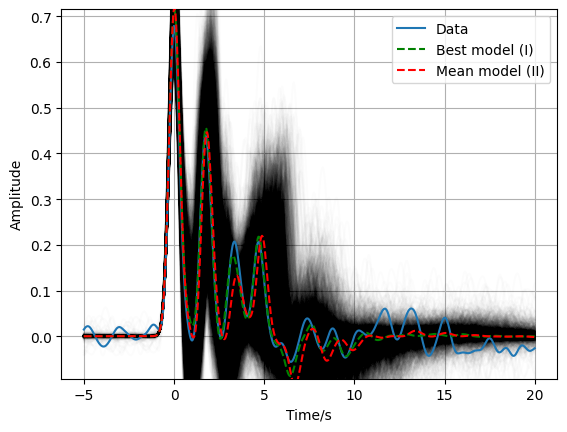

In [59]:
ax = rfi.plot_data(rfi.data, label="Data")
_ylim = ax.get_ylim()
for model in appraiser.samples[::15]:
    ax.plot(rfi._t, rfi.forward(model), c="k", alpha=0.01)
ax.get_lines()[0].set_zorder(10)
ax.plot(rfi._t, rfi.forward(best), "g--", label="Best model (I)", zorder=11)
ax.plot(rfi._t, rfi.forward(appraiser.mean), "r--", label="Mean model (II)", zorder=11)
ax.set_ylim(_ylim)
ax.legend()